# "Zillow Zing Zestimate Project"

## Background

*Zillow is an online real estate database company founded in 2006 - Wikipedia.* “Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today). The Zillow Zestimate Zing Project will predict the error between Zestimate and the sales price of a home. 

- Project By Ednalyn C. De Dios
- Codeup Data Science
- ADA Cohort
- 25 March 2019

## Project Planning

### Goal

- Develop a linear regression model that will best predict the log error of the Zestimate.

### Deliverables

1. Report
1. Jupyter Notebook

### Data Dictionary & Details


***We will be using 2016 data.***

- logerror: 
- bathroomcnt: 
- bedroomcnt: 
- calculatedfinishedsquarefeet: 
- fullbathcnt: 
- garagecarcnt: 
- roomcnt: 
- yearbuilt: 
- taxvalueddollarcnt: 
- taxamount: 
- regionidcounty: 
- regionidcity: 
- regionidzip: 
- regionidneighborhood: 

### Initial Thoughts, Ideas, Hypotheses

- In addition to the given columns variables), I think that location-related variables also have a role to play in driving the log error.

### Preparing the Environment

Libraries imported below for data wrangling, exploring, visualizing, and modeling will be used throughout the project.

In [56]:
# Wrangling
import pandas as pd
import math
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression

from env import user, host, password, path

#### Utilities
*TODO: Functions to export in the `util.py` later.*

In [97]:
def summarize_df(df):
    print("Summary of Data\n")
    print("Rows & Columns:\n")
    print(df.shape)
    print("Variables:\n")
    var_names = df.columns.values
    print(var_names)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nNumeric Summary Stats:\n")
    print(df.describe())
    print("\nTop 5 Values:\n")
    for var in var_names:
        print(var+":")
        print(df[var].value_counts().head())
        print('\n')
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nEnd of Summary")

def validate_tts(X_train, y_train, X_test, y_test):
    if X_train.shape[0] == y_train.shape[0]:
        print("X & y train rows ARE equal")
    else:
        print("X & y train rows ARE NOT equal")


    if X_test.shape[0] == y_test.shape[0]:
        print("X & y test rows ARE equal")
    else:
        print("X & y test rows ARE NOT equal")

    if train.shape[1] == test.shape[1]:
        print("Number of columns in train & test ARE equal")
    else:
        print("Number of columns in train & test ARE NOT equal")

    train_split = train.shape[0] / (train.shape[0] + test.shape[0])
    test_split = test.shape[0] / (train.shape[0] + test.shape[0])

    print("Train Split: %.2f" % train_split)
    print("Test Split: %.2f" % test_split)

### Data Acquisition

- Acquire the data via csv
- Generate cohesive dataset with recommended columns
- Add location-related columns (regionid...)


In [20]:
# Acquire the data via csv
train_df = pd.read_csv("train_2016_v2.csv", low_memory=False)
properties_df = pd.read_csv("properties_2016.csv", low_memory=False)

# Generate a cohesive dataset
df = pd.merge(train_df, properties_df, on='parcelid', how='inner')
df = df[['parcelid',
         'logerror',
         'bathroomcnt',
         'calculatedfinishedsquarefeet',
         'fullbathcnt',
         'garagecarcnt',
         'roomcnt',
         'yearbuilt',
         'taxvaluedollarcnt',
         'taxamount',
         'regionidzip',
         'regionidneighborhood'
        ]]

Log errors were filtered organically after merging.

In [21]:
# Check for null values in the columns
print(df.isnull().sum())

# Check number of rows and columns after merging
df.shape

parcelid                            0
logerror                            0
bathroomcnt                         0
calculatedfinishedsquarefeet      661
fullbathcnt                      1182
garagecarcnt                    60338
roomcnt                             0
yearbuilt                         756
taxvaluedollarcnt                   1
taxamount                           6
regionidzip                        35
regionidneighborhood            54263
dtype: int64


(90275, 12)

Discard unwanted columns.

In [22]:
# Remove these columns entirely due to high number of null values
df = df.drop(['regionidneighborhood', 'garagecarcnt'], axis=1)
df.sample(10)

,parcelid,logerror,bathroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount,regionidzip
77145,17099838,-0.0131,2.0,1369.0,2.0,6.0,1965.0,239082.0,2587.30,97113.0
1966,10819908,0.0516,2.0,1373.0,2.0,0.0,1950.0,263035.0,3374.51,96415.0
46038,14645427,-0.0111,2.0,921.0,2.0,0.0,1982.0,245950.0,3116.98,97078.0
64515,11032727,0.0354,2.0,1014.0,2.0,0.0,1949.0,270711.0,3380.08,96411.0
55883,14604756,-0.0010,2.5,1046.0,2.0,0.0,1998.0,398000.0,4453.52,97027.0
46049,12925748,-0.0030,2.0,1671.0,2.0,0.0,1954.0,304026.0,3912.05,96473.0
32619,11508207,-0.1875,3.0,2242.0,3.0,0.0,1998.0,1402966.0,15819.17,96117.0
45937,14727744,-0.0050,2.5,1422.0,2.0,0.0,1983.0,263054.0,2799.80,96948.0
29367,14470676,0.0030,3.0,2399.0,3.0,8.0,1986.0,676912.0,6902.20,96996.0
5574,12502248,0.0583,3.0,3106.0,3.0,0.0,1975.0,164433.0,5011.93,96241.0


Summarize the data using predefined function.

In [23]:
summarize_df(df)

Summary of Data

Rows & Columns:

(90275, 10)
Variables:

['parcelid' 'logerror' 'bathroomcnt' 'calculatedfinishedsquarefeet'
 'fullbathcnt' 'roomcnt' 'yearbuilt' 'taxvaluedollarcnt' 'taxamount'
 'regionidzip']

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 10 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
bathroomcnt                     90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
regionidzip                     90240 non-null float64
dtypes: float64(9), int64(1)
memory usage: 7.6 MB
None

Numeric Summary Stats:

           parcelid      logerror   b

### Data Preparation

Goal: leave this section with a dataset that is ready to be analyzed. 

In [24]:
# Discard rows where respective column contains null
df = df[df['calculatedfinishedsquarefeet'].notnull()]
df = df[df['fullbathcnt'].notnull()]
df = df[df['yearbuilt'].notnull()]
df = df[df['taxvaluedollarcnt'].notnull()]
df = df[df['taxamount'].notnull()]
df = df[df['regionidzip'].notnull()]

# Check for null values
print(df.isnull().sum())
df.sample(10)

parcelid                        0
logerror                        0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
fullbathcnt                     0
roomcnt                         0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
regionidzip                     0
dtype: int64


,parcelid,logerror,bathroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount,regionidzip
81685,10951238,0.0751,2.0,998.0,2.0,0.0,1992.0,356000.0,4592.84,96436.0
56679,14460946,0.0488,4.5,4366.0,4.0,0.0,1999.0,1424154.0,15004.36,96989.0
15288,11363119,0.0723,2.0,1622.0,2.0,0.0,1989.0,224243.0,2928.21,96398.0
71148,11194398,0.0227,3.0,2342.0,3.0,0.0,1965.0,76240.0,3773.96,97329.0
38283,11035936,0.2070,2.0,1300.0,2.0,0.0,1951.0,58993.0,859.60,96361.0
26997,12333515,0.1561,2.0,1436.0,2.0,0.0,1950.0,330640.0,4144.06,96101.0
7112,11635283,0.0100,2.0,1279.0,2.0,0.0,1926.0,938082.0,11695.19,96050.0
44454,17226164,0.0169,4.0,2750.0,4.0,9.0,1999.0,588765.0,6659.44,97118.0
11023,14266186,-0.0672,2.0,1755.0,2.0,7.0,1981.0,318519.0,4046.30,96958.0
32578,10719288,0.2799,2.0,1128.0,2.0,0.0,1959.0,182928.0,2353.31,96342.0


#### Create a variable, `colnames`, that is a list of the column names. 
Why? You will likely reference this variable later.

In [25]:
colnames = ['parcelid',
            'logerror',
            'bathroomcnt',
            'calculatedfinishedsquarefeet',
            'fullbathcnt',
            'roomcnt',
            'yearbuilt',
            'taxvaluedollarcnt',
            'taxamount',
            'regionidzip'
           ]
df.sample(10)

,parcelid,logerror,bathroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount,regionidzip
37772,14198936,-0.0274,2.0,1412.0,2.0,7.0,1980.0,537920.0,6450.10,97079.0
7303,10723199,-0.0356,3.0,2152.0,3.0,0.0,1964.0,92573.0,1410.67,96339.0
36897,11692386,0.1222,4.0,4532.0,4.0,0.0,1990.0,1891412.0,23153.48,96030.0
75630,11602188,-0.2120,3.0,1567.0,3.0,0.0,1926.0,72162.0,999.05,96016.0
63070,10729103,-0.1087,3.0,1623.0,3.0,0.0,1959.0,593000.0,7436.17,96389.0
59761,12748384,0.0247,2.0,1545.0,2.0,0.0,1955.0,378429.0,4897.52,96190.0
19172,17251332,-0.0090,3.0,2408.0,3.0,7.0,1964.0,434976.0,5004.48,97118.0
21334,10739659,0.0296,2.0,1781.0,2.0,0.0,1964.0,66449.0,1075.29,96337.0
77628,17254755,-0.0131,2.0,1274.0,2.0,5.0,1961.0,366120.0,4343.98,97118.0
43741,13026707,0.0723,3.0,1530.0,3.0,0.0,2013.0,384535.0,7695.42,96464.0


#### Identify the data types of each variable. Why? 
You need to make sure they are what makes sense for the data and the meaning of the data that lies in that variable. If it does not, make necessary changes.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88984 entries, 0 to 90274
Data columns (total 10 columns):
parcelid                        88984 non-null int64
logerror                        88984 non-null float64
bathroomcnt                     88984 non-null float64
calculatedfinishedsquarefeet    88984 non-null float64
fullbathcnt                     88984 non-null float64
roomcnt                         88984 non-null float64
yearbuilt                       88984 non-null float64
taxvaluedollarcnt               88984 non-null float64
taxamount                       88984 non-null float64
regionidzip                     88984 non-null float64
dtypes: float64(9), int64(1)
memory usage: 7.5 MB


Zip codes should be string objects.

In [34]:
# Convert from numeric to string
df['regionidzip'] = df['regionidzip'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88984 entries, 0 to 90274
Data columns (total 10 columns):
parcelid                        88984 non-null int64
logerror                        88984 non-null float64
bathroomcnt                     88984 non-null float64
calculatedfinishedsquarefeet    88984 non-null float64
fullbathcnt                     88984 non-null float64
roomcnt                         88984 non-null float64
yearbuilt                       88984 non-null float64
taxvaluedollarcnt               88984 non-null float64
taxamount                       88984 non-null float64
regionidzip                     88984 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 7.5+ MB


,parcelid,logerror,bathroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount,regionidzip
20870,11717291,-0.2692,2.0,1724.0,2.0,0.0,1919.0,37072.0,4265.73,96043.0
71069,14670219,0.4061,2.0,1334.0,2.0,6.0,1976.0,260228.0,2664.86,96963.0
45457,12653173,0.0119,1.0,1140.0,1.0,0.0,1923.0,532000.0,5637.94,96221.0
29490,12613421,0.0129,1.0,1358.0,1.0,0.0,1952.0,405992.0,5200.40,96217.0
16848,12215684,0.0853,2.0,1387.0,2.0,0.0,2001.0,101786.0,1547.01,95983.0
86099,10910511,0.0188,3.0,1506.0,3.0,0.0,1974.0,111956.0,1494.89,96449.0
63686,14726626,0.0440,2.0,1160.0,2.0,0.0,1981.0,177973.0,2140.04,96225.0
27091,12458086,0.0677,1.0,594.0,1.0,0.0,1923.0,128367.0,1641.71,96239.0
21271,10834790,0.0296,1.0,813.0,1.0,0.0,1949.0,198208.0,2596.86,96415.0
88825,10723156,0.0218,3.0,1970.0,3.0,0.0,1987.0,458805.0,5835.38,96342.0


*TODO: Need to remove .0 from the zip codes.*

In [45]:
# Strip residual decimal
# df.regionidzip = df.regionidzip.replace('.0', '')
df.sample(10)

,parcelid,logerror,bathroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount,regionidzip
5185,17198489,0.0247,2.5,1696.0,2.0,6.0,1957.0,526000.0,5765.78,97097.0
57671,13051499,0.0060,3.0,2598.0,3.0,0.0,1970.0,138515.0,2208.20,96469.0
73862,12159470,-0.0171,1.0,1129.0,1.0,0.0,1913.0,349055.0,4392.49,96265.0
28008,14165594,-0.0736,3.5,3742.0,3.0,0.0,2007.0,1229452.0,14177.54,97078.0
9024,12142216,0.0070,5.0,3902.0,5.0,0.0,1998.0,1054888.0,12399.83,96268.0
84925,12339413,-0.0020,1.0,836.0,1.0,0.0,1962.0,280000.0,3596.69,96220.0
13253,12550666,0.0060,2.0,1956.0,2.0,0.0,1919.0,232998.0,3063.36,96245.0
53279,13058900,-0.0222,3.0,3225.0,3.0,0.0,1987.0,551526.0,11922.97,96505.0
43637,17233560,0.0040,2.5,2035.0,2.0,6.0,1970.0,289612.0,3474.82,97116.0
69468,11342015,-0.0243,3.0,1490.0,3.0,0.0,1989.0,319338.0,4490.92,96373.0


#### Identify the columns that have missing values and the number of missing values in each column. 
Why? Missing values are going to cause issues down the line so you will need to handle those appropriately. For each variable with missing values, if it makes sense to replace those missing with a 0, do so. For those where that doesn't make sense, decide if you should drop the entire observations (rows) that contain the missing values, or drop the entire variable (column) that contains the missing values.

In [46]:
df.isnull().sum()

parcelid                        0
logerror                        0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
fullbathcnt                     0
roomcnt                         0
yearbuilt                       0
taxvaluedollarcnt               0
taxamount                       0
regionidzip                     0
dtype: int64

#### Create a list of the independent variable names (aka attributes) and assign it to `x_vars` 
Why? During exploration, you will likely use this list to refer to the attribute names.

In [64]:
x_vars = ['bathroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'roomcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount',
          'regionidzip'
         ]

std_x_vars = ['bathroom_count',
          'square_feet',
          'full_bath_count',
          'room_count',
          'year_built',
          'tax_value_count',
          'tax_amount',
          'region_zip'
         ]

#### Clearly identify your dependent (target) variable. 
- logerror

In [48]:
y_vars = 'logerror'

#### View the distribution of the numeric variables
- plot a histogram and box plot of each variable. 
- Why? To see the distribution, skewness, outliers, and unit scales. You will use this information in your decision of whether to normalize, standardize or neither.

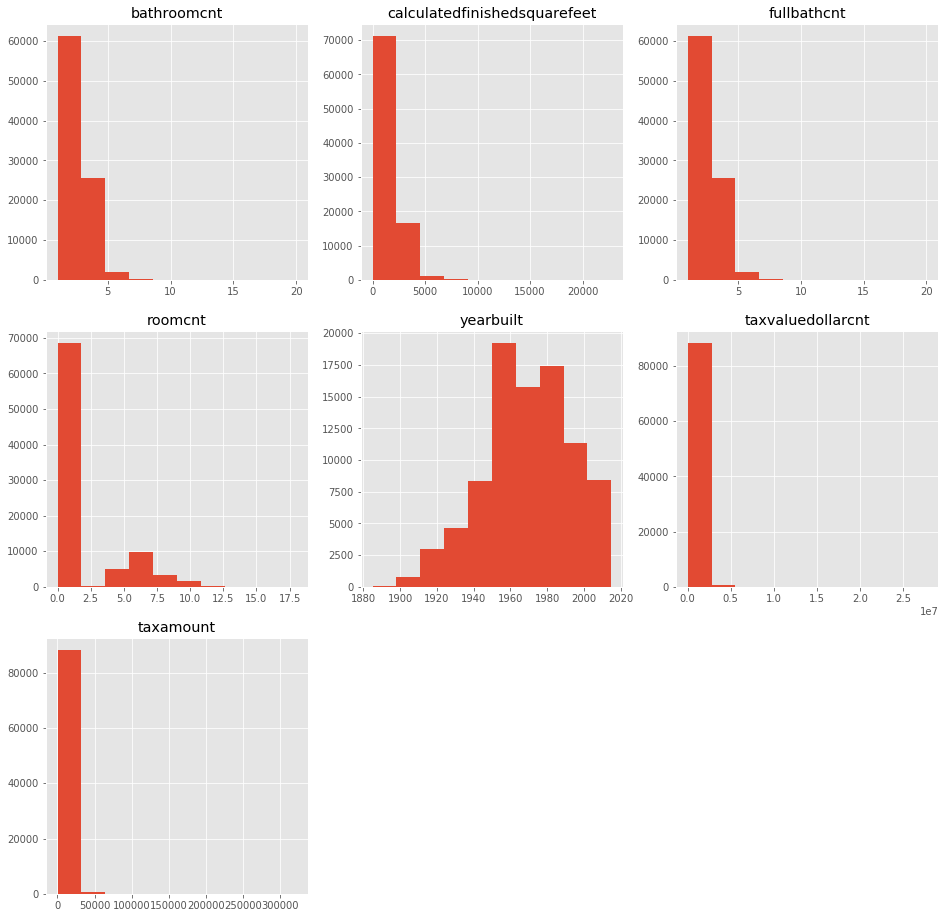

In [51]:
plt.figure(figsize=(16,16))

for i, col in enumerate(['bathroomcnt',
          'calculatedfinishedsquarefeet',
          'fullbathcnt',
          'roomcnt',
          'yearbuilt',
          'taxvaluedollarcnt',
          'taxamount'
         ]):
    plot_number = i + 1
    series = df[col]
    plt.subplot(3,3,plot_number)
    plt.title(col)
    series.hist()

#### BONUS:  Data standardization 
Create a new data frame that is the min-max normalization of the independent variable in the original data frame (+ the original dependent variable). You will normalize each of the numeric independent variables independently, i.e. using the min and max of each variable, not the min/max of the whole dataframe. Why? Regression is very sensitive to difference in units. It will be almost impossible to extract a meaningful linear regression model with such extreme differences in scale. For more context, see: https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
You will use this dataframe in the future analysis.

In [53]:
std_df = df.drop(colnames, axis=1)

std_df['parcel_id'] = df.parcelid
std_df['log_error'] = df.logerror

std_df['bathroom_count'] = (df.bathroomcnt - df.bathroomcnt.min()) / (df.bathroomcnt.max() - df.bathroomcnt.min())
std_df['square_feet'] = (df.calculatedfinishedsquarefeet - df.calculatedfinishedsquarefeet.min()) / (df.calculatedfinishedsquarefeet.max() - df.calculatedfinishedsquarefeet.min())
std_df['full_bath_count'] = (df.fullbathcnt - df.fullbathcnt.min()) / (df.fullbathcnt.max() - df.fullbathcnt.min())
std_df['room_count'] = (df.roomcnt - df.roomcnt.min()) / (df.roomcnt.max() - df.roomcnt.min())
std_df['year_built'] = (df.yearbuilt - df.yearbuilt.min()) / (df.yearbuilt.max() - df.yearbuilt.min())
std_df['tax_value_count'] = (df.taxvaluedollarcnt - df.taxvaluedollarcnt.min()) / (df.taxvaluedollarcnt.max() - df.taxvaluedollarcnt.min())
std_df['tax_amount'] = (df.taxamount - df.taxamount.min()) / (df.taxamount.max() - df.taxamount.min())

std_df['region_zip'] = df.regionidzip

std_df.sample(10)

,parcel_id,log_error,bathroom_count,square_feet,full_bath_count,room_count,year_built,tax_value_count,tax_amount,region_zip
68092,14323973,0.0583,0.289474,0.456616,0.263158,0.000000,0.846154,0.150051,0.151850,96975.0
81931,10966655,0.2398,0.052632,0.065438,0.052632,0.000000,0.615385,0.010347,0.011318,96368.0
54244,14481317,0.0227,0.052632,0.062976,0.052632,0.000000,0.784615,0.022879,0.020483,96989.0
86008,11769752,0.0000,0.157895,0.156031,0.157895,0.000000,0.600000,0.012427,0.013889,95992.0
73764,12168287,-0.0161,0.052632,0.086108,0.052632,0.000000,0.400000,0.017015,0.017824,96265.0
39106,11014719,-0.0253,0.105263,0.106953,0.105263,0.000000,0.630769,0.019206,0.020453,96370.0
624,12710013,0.1647,0.105263,0.158626,0.105263,0.000000,0.600000,0.031242,0.031602,96122.0
71593,11296854,0.0257,0.105263,0.118915,0.105263,0.000000,0.923077,0.007927,0.014284,97318.0
71164,13961982,0.1275,0.157895,0.123708,0.157895,0.333333,0.607692,0.023421,0.023031,97016.0
88951,10733353,0.0010,0.052632,0.107085,0.052632,0.000000,0.538462,0.020105,0.021532,96389.0


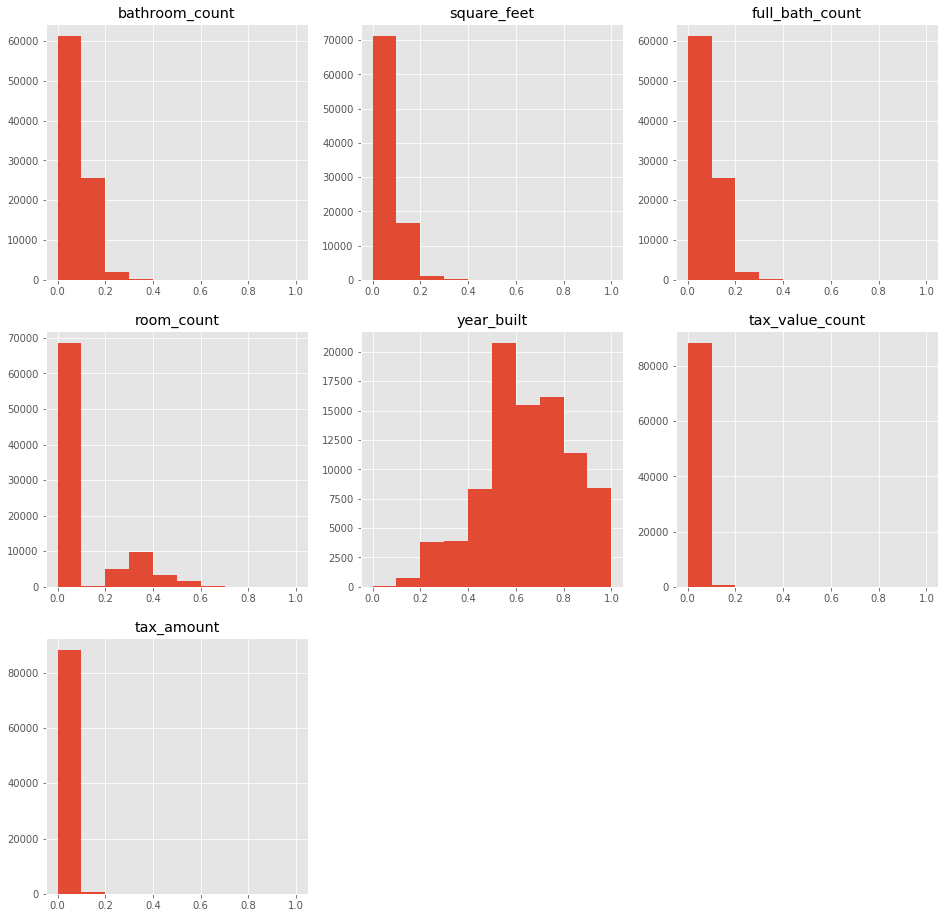

In [54]:
plt.figure(figsize=(16,16))

for i, col in enumerate(['bathroom_count',
          'square_feet',
          'full_bath_count',
          'room_count',
          'year_built',
          'tax_value_count',
          'tax_amount'
         ]):
    plot_number = i + 1
    series = std_df[col]
    plt.subplot(3,3,plot_number)
    plt.title(col)
    series.hist()

### Data Exploration

Goal is to address each of the questions you posed in your planning & brainstorming through visual or statistical analysis.

When you have completed this step, you will have the findings from your analysis that will be used in your final report, the answers to your questions and your customer's questions that will reach the goal. 

The idea and code below were inspired and adapted from at https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-zillow-prize by Sudalai Raj Kumar (SRK).

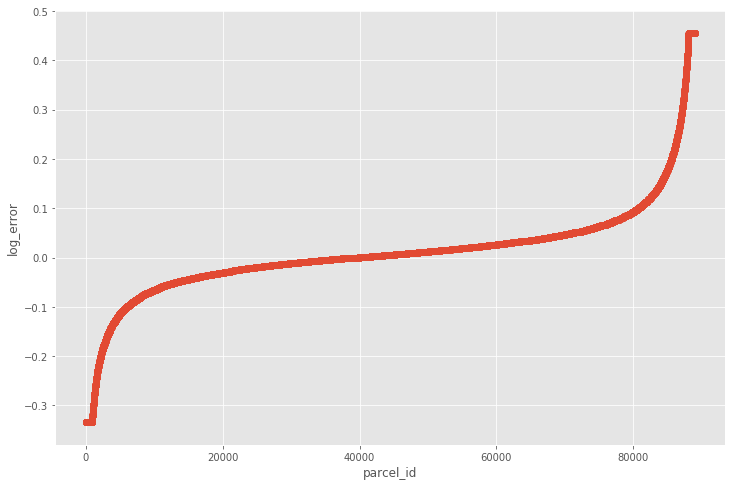

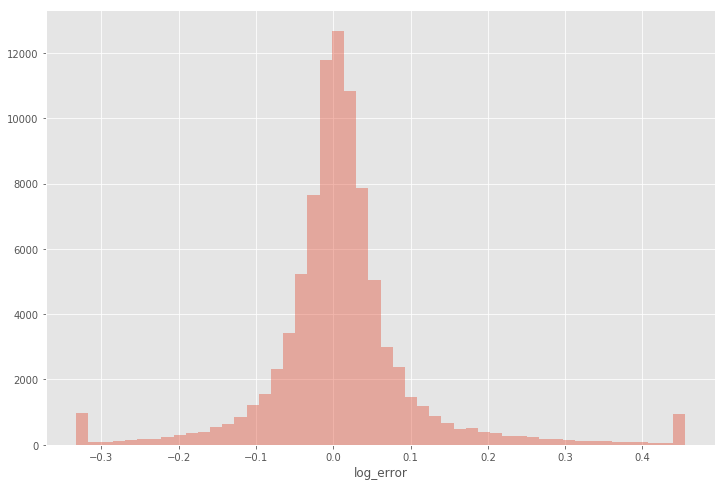

In [91]:
# Plot the log error
plt.figure(figsize=(12,8))
plt.scatter(range(std_df.shape[0]), np.sort(std_df.log_error.values))
plt.xlabel('parcel_id')
plt.ylabel('log_error')
plt.show()

# Remove outliers
ulimit = np.percentile(std_df.log_error.values, 99)
llimit = np.percentile(std_df.log_error.values, 1)
std_df['log_error'].loc[std_df['log_error']>ulimit] = ulimit
std_df['log_error'].loc[std_df['log_error']<llimit] = llimit

# Plot the distribution
plt.figure(figsize=(12,8))
sns.distplot(std_df.log_error.values, bins=50, kde=False)
plt.xlabel('log_error')
plt.show()

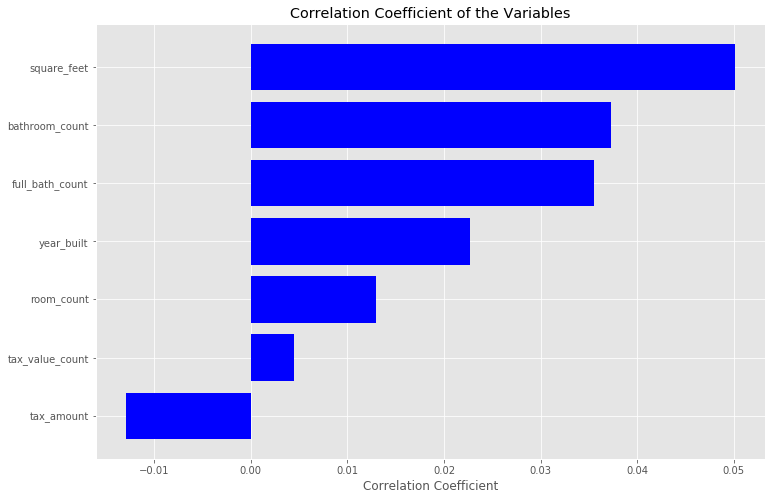

In [90]:
# Correlation coefficient of each of these variables
std_x_vars = [col for col in std_df.columns if col not in ['log_error'] if std_df[col].dtype=='float64']

labels = []
values = []
for col in std_x_vars:
    labels.append(col)
    values.append(np.corrcoef(std_df[col].values, std_df.log_error.values)[0,1])
correlation_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
correlation_df = correlation_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 1
fig, ax = plt.subplots(figsize=(12,8))
rects = ax.barh(ind, np.array(correlation_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(correlation_df.col_labels.values)
ax.set_xlabel("Correlation Coefficient")
ax.set_title("Correlation Coefficient of the Variables")
#autolabel(rects)
plt.show()

#### Split data into training and test datasets

In [99]:
# test_train_split
X = std_df.drop(['parcel_id','log_error'], axis=1)
print(X.head())

y = std_df[['log_error']]
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)

print()
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)
print()

test = pd.concat([X_test, y_test], axis=1)

print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)
print()

validate_tts(X_train, y_train, X_test, y_test)

   bathroom_count  square_feet  full_bath_count  room_count  year_built  \
0        0.052632     0.073970         0.052632    0.000000    0.569231   
1        0.131579     0.099433         0.105263    0.000000    0.992308   
2        0.105263     0.097410         0.105263    0.000000    0.423077   
3        0.052632     0.036809         0.052632    0.000000    0.784615   
4        0.078947     0.100312         0.052632    0.444444    0.738462   

   tax_value_count  tax_amount region_zip  
0         0.012978    0.020774    96370.0  
1         0.021099    0.031390    96962.0  
2         0.004320    0.035526    96293.0  
3         0.008824    0.009319    96222.0  
4         0.015659    0.016900    96961.0  
   log_error
0     0.0276
1    -0.1684
2    -0.0040
3     0.0218
4    -0.0050

Train columns:  ['bathroom_count', 'square_feet', 'full_bath_count', 'room_count', 'year_built', 'tax_value_count', 'tax_amount', 'region_zip', 'log_error']
Train dimensions (rows, columns): (71187, 9)

Tes

#### Create a jointplot for each independent variable (normalized version) with the dependent variable. 

Be sure you have Pearson's r and p-value annotated on each plot.

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


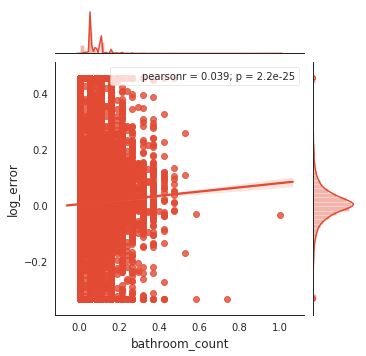

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


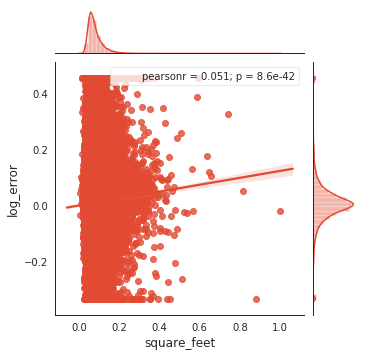

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


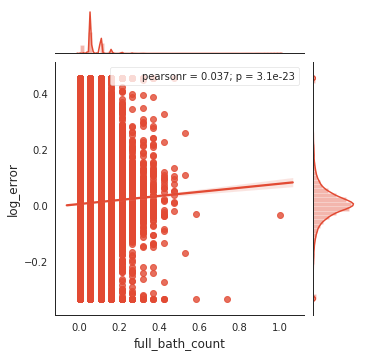

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


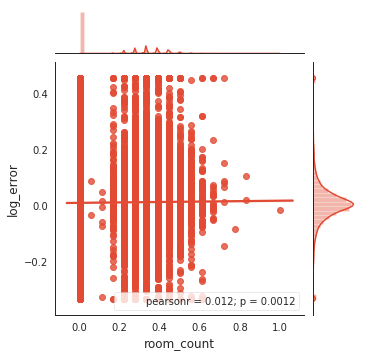

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


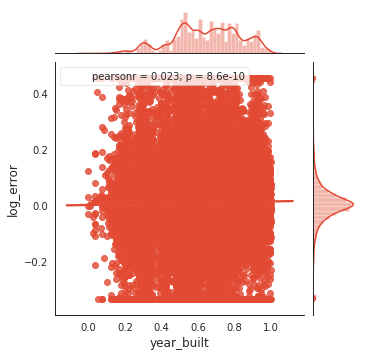

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


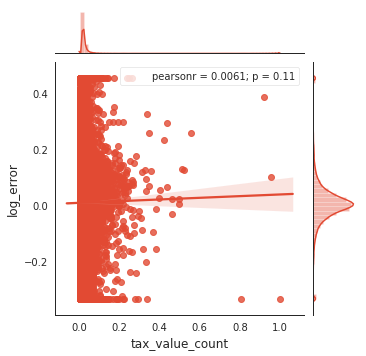

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


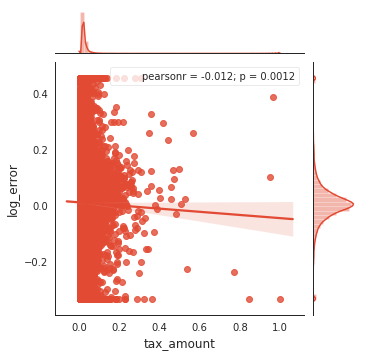

In [105]:
with sns.axes_style('white'):
    j = sns.jointplot("bathroom_count", "log_error", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot("square_feet", "log_error", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot("full_bath_count", "log_error", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot("room_count", "log_error", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot("year_built", "log_error", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot("tax_value_count", "log_error", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

with sns.axes_style('white'):
    j = sns.jointplot("tax_amount", "log_error", data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)
plt.show()

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 

You may want to use a normalized dataframe (if you did that) or adjust the axis scale (set to logarithmic, e.g) so you can more clearly view the interactions.

ValueError: color kwarg must have one color per data set. 71187 data sets and 1 colors were provided

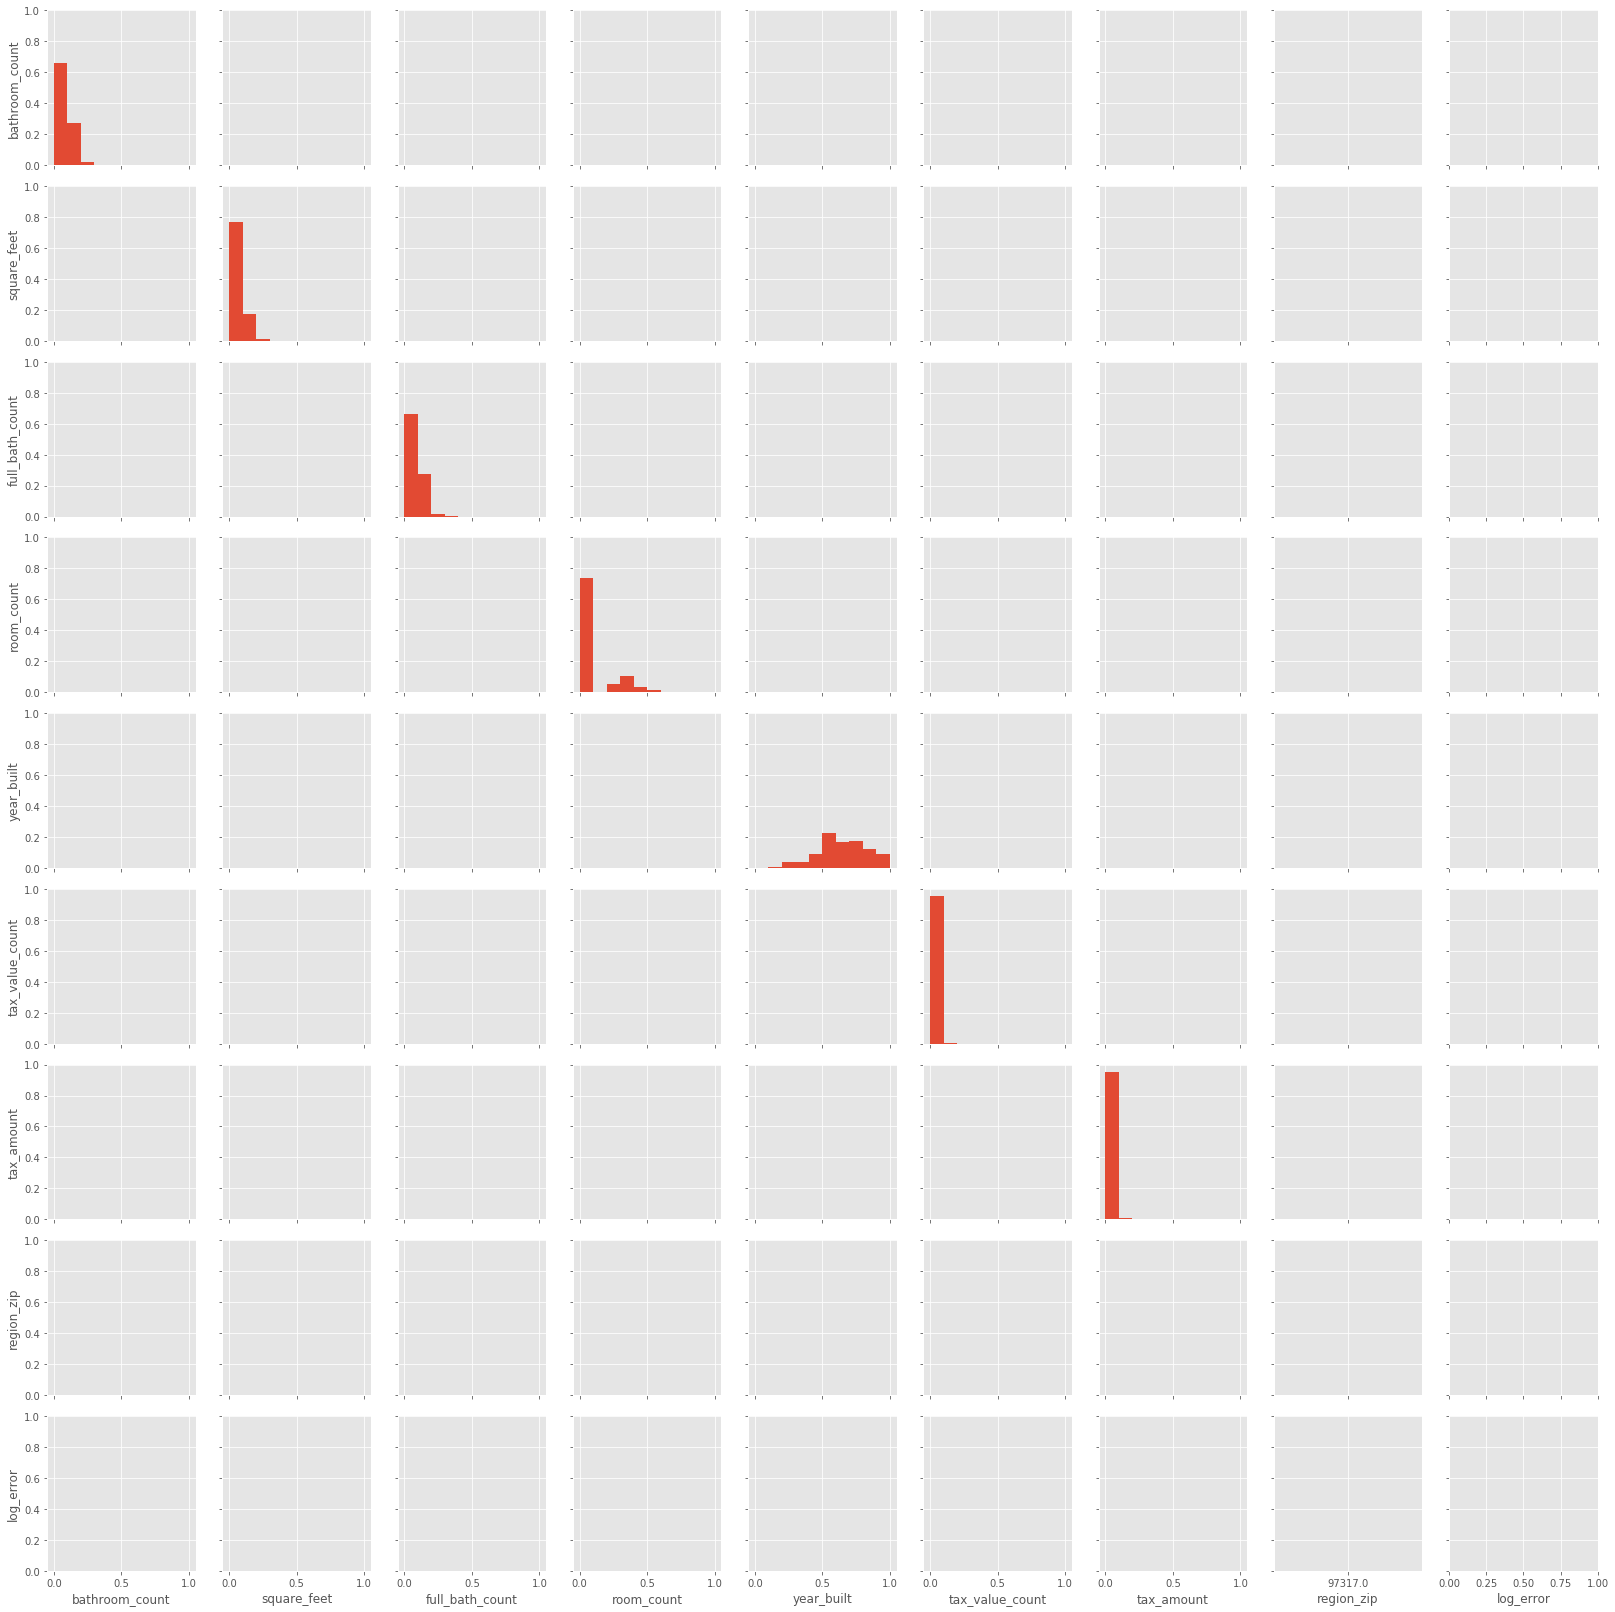

In [106]:
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

#### Create a heatmap of the correlation between each variable pair.

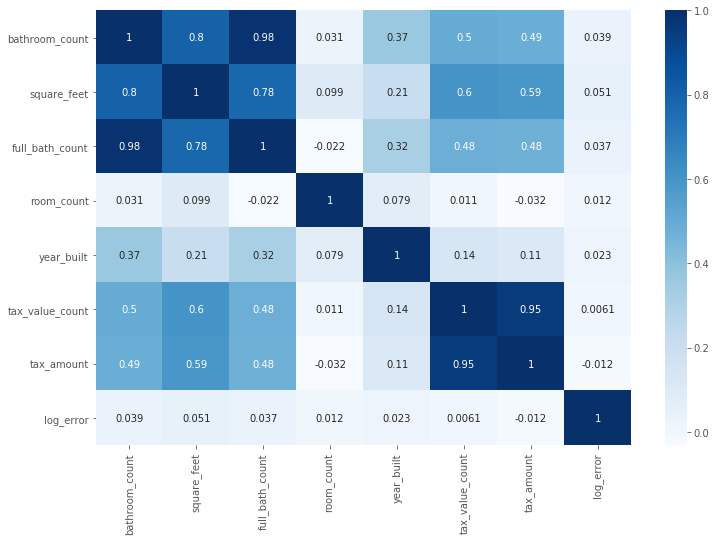

In [108]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

#### Summarize your conclusions from all of these steps.  

#### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms? 
Run a t-test to test this difference.

#### Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)

### Data Modeling

#### Feature Engineering & Selection

#### Are there new features you could create based on existing features that might be helpful? 

Come up with at least one possible new feature that is a calculation from 2+ existing variables. 

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

#### Summarize your conclusions and next steps from your analysis in above. 
What will you try when developing your model? (which features to use/not use/etc)

#### Train & Test Model

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

- Make any changes as necessary to improve your model.

- Identify the best model after all training

- Compare the models by plotting the predictions of each model with actual values (see plot right above section 12 in 'Regression in Python' lesson

(the predictions are a 1 x 83 two dimensional matrix, but we want just a single array of predictions. We can use the .ravel method to achieve this.)

`pd.DataFrame({'actual': y_train.final_grade,  
              'lm1': y_pred_lm1.ravel(),  
              'lm2': y_pred_lm2.ravel()})\  
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\  
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')  

plt.plot([60, 100], [60, 100], c='black', ls=':')  
plt.ylim(60, 100)  
plt.xlim(60, 100)  
plt.title('Predicted vs Actual Final Grade')`  

#### Predict & evaluate on out-of-sample data (test)    

- Plot the residuals from your out-of-sample predictions.

- Summarize your expectations about how you estimate this model will perform in production.